Import libraries and define k

In [655]:
import numpy as np
import cupy as cp
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

Read data and split it to train and test sets. Define k.

In [656]:
k = 3
n_test = 1000

data = np.loadtxt( "MLoGPU_data1_train.csv", delimiter = ",", dtype = np.float32 )
x_data = np.array( data[ :, 0:-1 ] )
y_data = np.array( data[ :, -1 ] ).reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split( x_data, y_data, test_size = n_test)#, stratify = y_data )


In [657]:
# Different approach, not working
'''l2distance = cp.RawKernel(r"""
  extern "C" __global__ 
  void euclidean_distance( float* a, float* b, float* c, int vec_length, int vec_num) {

    int thread_index = (blockIdx.y * blockDim.x * blockDim.y) + (threadIdx.y * blockDim.x) + threadIdx.x;
    int feature_index = threadIdx.x;
    int vec_index = blockIdx.y * blockDim.y + threadIdx.y;
  
    if ( thread_index > vec_num  ) {
      return;
    }

    float term_diff = b[ feature_index ] - a[ thread_index ];
    float difference = term_diff*term_diff;
    
    c[ vec_index ] += difference;
    
    __syncthreads();
    
    float sqrtdiff = sqrtf( c[ vec_index ] );
    
    __syncthreads();
  
    c[ vec_index ] = sqrtdiff;
       
  }
""", "euclidean_distance")'''

'l2distance = cp.RawKernel(r"""\n  extern "C" __global__ \n  void euclidean_distance( float* a, float* b, float* c, int vec_length, int vec_num) {\n\n    int thread_index = (blockIdx.y * blockDim.x * blockDim.y) + (threadIdx.y * blockDim.x) + threadIdx.x;\n    int feature_index = threadIdx.x;\n    int vec_index = blockIdx.y * blockDim.y + threadIdx.y;\n  \n    if ( thread_index > vec_num  ) {\n      return;\n    }\n\n    float term_diff = b[ feature_index ] - a[ thread_index ];\n    float difference = term_diff*term_diff;\n    \n    c[ vec_index ] += difference;\n    \n    __syncthreads();\n    \n    float sqrtdiff = sqrtf( c[ vec_index ] );\n    \n    __syncthreads();\n  \n    c[ vec_index ] = sqrtdiff;\n       \n  }\n""", "euclidean_distance")'

Defining kernel code

In [658]:
l2distance = cp.RawKernel(r"""
  extern "C" __global__ 
  void euclidean_distance( float* a, float* b, float* c, int vec_length, int vec_num) {

    int thread_index = blockIdx.x * blockDim.x + threadIdx.x;
    float term_diff = 0;
    float difference = 0;
    
    if ( thread_index > vec_num  ) {
      return;
    }

    for ( int ii = 0; ii < vec_length; ++ii ) {
      
      term_diff = 0;

      int vec_index = vec_length*thread_index + ii;
    
      term_diff = b[ii] - a[ vec_index ];
      difference += term_diff*term_diff;
      
      __syncthreads();

    }
    c[ thread_index ] = sqrtf( difference );    
  }
""", "euclidean_distance")

Defining constants and block and grid dims

In [659]:
N_training = X_train.shape[0]
N_features = X_train.shape[1]

numThreadsNeeded = N_training * N_features
numBlocks = np.int32( np.ceil( numThreadsNeeded / 1000 ) )

gridDim = np.int32( np.ceil( N_training / 1000 ) )

block_dims = ( 100, 10, 1 )
grid_dims = ( numBlocks, 1, 1 )


Doing the classification

In [660]:
# Move data to device
training_vecs_gpu = cp.asarray( X_train )
distances = cp.empty( [ N_training, 1 ], dtype = np.float32 )
predictions_gpu = np.zeros( ( X_test.shape[0], 1 ), dtype = np.int16 )

# For each test vector
start_time = time.perf_counter()
for ii in range( X_test.shape[0] ):
    
    test_vec = X_test[ ii, : ]
    test_vec_gpu = cp.asarray( test_vec )

    # Executing the kernel
    l2distance( grid_dims, block_dims, ( training_vecs_gpu, test_vec_gpu, distances, N_features, N_training ) )
    
    # Sorting the distances 
    distance_data = cp.concatenate( ( distances, cp.asarray( Y_train ) ), axis = 1 )
    
    ind = cp.argsort( distance_data[ :, 0 ] )
    sorted_distances = distance_data[ ind ]
    
    kNearest = sorted_distances[ 0:k, 1 ]
    unique, counts = cp.unique( kNearest, return_counts = True )
    
    label_ind = cp.argsort( counts )[-1]
    predicted_label = unique[ label_ind ]
        
    predictions_gpu[ii] = np.int16( predicted_label.get() )
    
time_GPU = round( ( time.perf_counter() - start_time ), 3 )


Visualizing and evaluating results

[[  0   0   1   0   2   0   0]
 [  0   2  16  12   2   0   0]
 [  0   4 173 114  21   5   0]
 [  0   2  66 256  68  16   0]
 [  0   0   9  69 101  22   0]
 [  0   0   1  14  14   8   0]
 [  0   0   0   1   0   1   0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.25      0.06      0.10        32
         5.0       0.65      0.55      0.59       317
         6.0       0.55      0.63      0.59       408
         7.0       0.49      0.50      0.49       201
         8.0       0.15      0.22      0.18        37
         9.0       0.00      0.00      0.00         2

    accuracy                           0.54      1000
   macro avg       0.30      0.28      0.28      1000
weighted avg       0.54      0.54      0.54      1000



c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

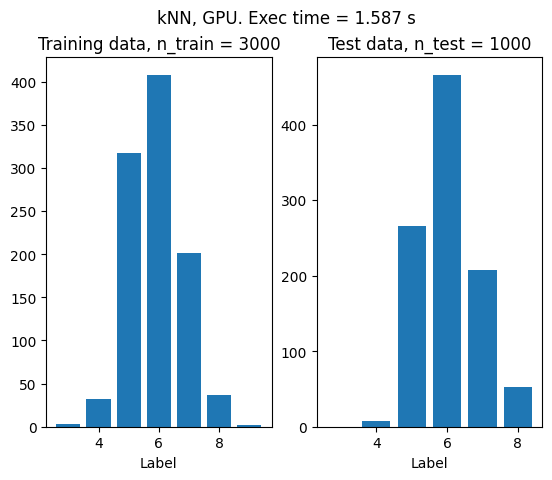

In [661]:
unique_labels = np.unique( data[ :, -1 ] )

Y_test_bins = np.bincount( np.squeeze( Y_test ).astype( np.int16 ) )[3:]
predicted_bins = np.bincount( np.squeeze( predictions_gpu ) )[3:]

fig, axarr = plt.subplots(1,2)

axarr[0].bar( unique_labels[ 0:len( Y_test_bins )], Y_test_bins ) 
titlestr = 'Training data, n_train = ' + str( y_data.shape[0] - n_test )
axarr[0].set_title( titlestr )
axarr[0].set( xlabel = 'Label' )

axarr[1].bar( unique_labels[ 0:len( predicted_bins ) ], predicted_bins )
titlestr = 'Test data, n_test = ' + str( n_test )
axarr[1].set_title( titlestr )
axarr[1].set( xlabel = 'Label' )

titlestr = "kNN, GPU. Exec time = " + str( time_GPU ) + " s"
fig.suptitle( titlestr )

print( confusion_matrix( Y_test, predictions_gpu ) )
print( classification_report( Y_test, predictions_gpu ) )

Implementation using CPU for comparison

c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Us

[[  0   0   2   0   1   0   0]
 [  1   5  16   9   1   0   0]
 [  2  15 185 105  10   0   0]
 [  0   8  94 262  40   4   0]
 [  1   2  25  75  88  10   0]
 [  1   0   3  15  12   6   0]
 [  0   0   0   2   0   0   0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.17      0.16      0.16        32
         5.0       0.57      0.58      0.58       317
         6.0       0.56      0.64      0.60       408
         7.0       0.58      0.44      0.50       201
         8.0       0.30      0.16      0.21        37
         9.0       0.00      0.00      0.00         2

    accuracy                           0.55      1000
   macro avg       0.31      0.28      0.29      1000
weighted avg       0.54      0.55      0.54      1000



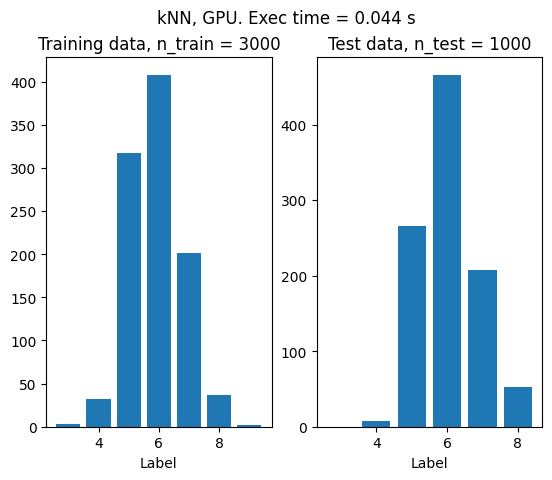

In [662]:

knn_cpu = KNeighborsClassifier( n_neighbors = k )
knn_cpu.fit( X_train, Y_train )

start_time = time.perf_counter()

predictions_cpu = knn_cpu.predict( X_test )
predicted_bins = np.bincount( np.squeeze( predictions_gpu ) )[3:]

time_CPU = round( ( time.perf_counter() - start_time ), 3 )

fig, axarr = plt.subplots(1,2)

# Visualizing and evaluation
axarr[0].bar( unique_labels[ 0:len( Y_test_bins )], Y_test_bins ) 
titlestr = 'Training data, n_train = ' + str( y_data.shape[0] - n_test )
axarr[0].set_title( titlestr )
axarr[0].set( xlabel = 'Label' )

axarr[1].bar( unique_labels[ 0:len( predicted_bins ) ], predicted_bins )
titlestr = 'Test data, n_test = ' + str( n_test )
axarr[1].set_title( titlestr )
axarr[1].set( xlabel = 'Label' )

titlestr = "kNN, GPU. Exec time = " + str( time_CPU ) + " s"
fig.suptitle( titlestr )

print( confusion_matrix( Y_test, predictions_cpu ) )
print( classification_report( Y_test, predictions_cpu ) )